In [ ]:
%pip install thefuzz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
booking_data = pd.read_csv('./processed_booking_snapshot_2025-03-09.csv')
agoda_data = pd.read_csv('./processed_agoda_snapshot_2025-03-09.csv')
booking_data.columns

Index(['name', 'original_price', 'discounted_price', 'discount',
       'review_score', 'review_title', 'number_of_reviews', 'star_rating',
       'is_apartment', 'neighborhood', 'kms_from_centre', 'location_score',
       'bed_type', 'room_type', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'discounted_price_per_night',
       'original_price_per_night', 'review_title_rank', 'bed_type_rank',
       'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights'],
      dtype='object')

In [3]:
booking_data['breakfast_included'] = booking_data['breakfast_included'].astype(bool).astype(int)
booking_data['free_cancellation'] = booking_data['free_cancellation'].astype(bool).astype(int)
booking_data['prepayment_needed'] = booking_data['prepayment_needed'].astype(bool).astype(int)

booking_data['price'] = booking_data['discounted_price_per_night']

booking_data.drop(columns=['discount', 'original_price', 'discounted_price',
        'review_title',
       'is_apartment', 'neighborhood', 'kms_from_centre',
       'bed_type', 'room_type', 
       'original_price_per_night', 'review_title_rank', 'bed_type_rank', 'discounted_price_per_night'
       ], inplace=True)

booking_data.fillna(booking_data['location_score'].min(), inplace=True)

agoda_data['price'] = agoda_data['discounted_price']
agoda_data.drop(columns=['discounted_price'], inplace=True)


## Normalize names

In [4]:
import re
import pandas as pd

def normalize_name(name):
    """
    Normalizes the name by converting to lowercase, removing ignored substrings,
    punctuation, and extra spaces.
    """
    if pd.isnull(name) or not name:
        return ""
    # Convert to lowercase.
    name = name.lower()
    # Remove punctuation; adjust regex as needed.
    name = re.sub(r'[^\w\s]', '', name)
    # Remove extra spaces.
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [5]:
agoda_data['name'] = agoda_data['name'].apply(normalize_name)
booking_data['name'] = booking_data['name'].apply(normalize_name)

# Combine simialiar hotel names

In [6]:
agoda_names = agoda_data['name'].unique()
booking_names = booking_data['name'].unique()
agoda_set = set(agoda_names)
booking_set = set(booking_names)

intersection_set = agoda_set & booking_set

agoda_only_set = agoda_set - booking_set
booking_only_set = booking_set - agoda_set

intersection = list(intersection_set)
agoda_only = list(agoda_only_set)
agoda_only.sort()
booking_only = list(booking_only_set)
booking_only.sort()

print("Intersection:", len(intersection))
print("Agoda Only:", len(agoda_only))
print("Booking Only:", len(booking_only))

Intersection: 188
Agoda Only: 393
Booking Only: 175


As we can see from the result of the code above, some names of hotels are the same with slight differences. To mitigate this problem while merging the datasets, we  will use a similiaty score to group similiar names together.

For example the AC hotel is listed as `Best Western PREMIER Herald Square` on booking, but on agoda it is listed as `Best Western Premier Herald Square`
##  Fuzz Names

### Find similiarities
The `token_set_ratio` is a method from fuzzy string matching that first splits each string into individual words (tokens) and converts them into a set to ignore duplicate words and their order. It then computes a similarity score based solely on the common tokens between the two strings. This is especially useful for comparing names or phrases where the order of words might differ or where one string might have extra words that don’t change its overall identity.

We used it to know if there is a full inclusion between names from two sets, without ordering, and by that we knew if two hotels are the same one.


In [7]:
import pandas as pd
from thefuzz import fuzz


threshold = 100
similar_matches = []

for agoda in agoda_only:
    norm_agoda = normalize_name(agoda)
    best_match = None
    best_score = 0
    for booking in booking_only:
        norm_booking = normalize_name(booking)
        score = fuzz.token_set_ratio(norm_agoda, norm_booking)
        if score > best_score:
            best_score = score
            best_match = booking
    # If the best match meets or exceeds the threshold, record the pair.
    if best_score >= threshold:
        canonical = agoda if len(agoda) < len(best_match) else best_match
        similar_matches.append((agoda, best_match, best_score, canonical))

# Output the matched pairs
print(f"{len(similar_matches)} Similar matches between agoda_only and booking_only (ignoring substrings):")
for agoda_name, booking_name, score, canonical in similar_matches:
    print(f"{canonical}: Agoda: '{agoda_name}' <--> Booking: '{booking_name}' (Score: {score})")


100 Similar matches between agoda_only and booking_only (ignoring substrings):
ac hotel new york downtown: Agoda: 'ac hotel new york downtown' <--> Booking: 'ac hotel by marriott new york downtown' (Score: 100)
ac hotel new york times square: Agoda: 'ac hotel new york times square' <--> Booking: 'ac hotel by marriott new york times square' (Score: 100)
ace hotel: Agoda: 'ace hotel' <--> Booking: 'ace hotel new york' (Score: 100)
park central: Agoda: 'aka central park' <--> Booking: 'park central' (Score: 100)
ameritania at times square: Agoda: 'ameritania hotel at times square' <--> Booking: 'ameritania at times square' (Score: 100)
aura hotel times square: Agoda: 'aura hotel times square' <--> Booking: 'aura hotel times square newly renovated' (Score: 100)
belvedere hotel: Agoda: 'belvedere hotel' <--> Booking: 'the belvedere hotel' (Score: 100)
candlewood suites nyc times square: Agoda: 'candlewood suites nyc times square' <--> Booking: 'candlewood suites nyc times square by ihg' (Sc

## Transform names to canonical

In [8]:
# transform the names from all hotels inplace at the dataframes
for agoda, booking, _score, canonical in similar_matches:
    booking_data.loc[booking_data['name'] == booking, 'name'] = canonical
    agoda_data.loc[agoda_data['name'] == agoda_name, 'name'] = canonical


In [9]:
def add_check_in_col(df):
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
    df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
    df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [10]:
add_check_in_col(booking_data)
add_check_in_col(agoda_data)

In [11]:
booking_data = booking_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])
agoda_data = agoda_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])

In [12]:
print(booking_data.columns)
print(agoda_data.columns)

Index(['name', 'review_score', 'number_of_reviews', 'star_rating',
       'location_score', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights', 'price',
       'checkin_date', 'checkin_day'],
      dtype='object')
Index(['name', 'star_rating', 'review_score', 'number_of_reviews',
       'distance_from_center', 'free_cancellation', 'prepayment_needed',
       'breakfast_included', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'price', 'checkin_date', 'checkin_day'],
      dtype='object')


# Merge the DataFrames

In [13]:
merged_data = pd.merge(booking_data, agoda_data, on=['name', 'checkin_date','length_of_stay', 'snapshot_date', 'time_to_travel'], suffixes=('_booking', '_agoda'), how='inner')

In [14]:
print(booking_data.__len__())
print(agoda_data.__len__())
print(merged_data.__len__())
display(merged_data)


14235
26853
4932


,name,review_score_booking,number_of_reviews_booking,star_rating_booking,location_score,breakfast_included_booking,free_cancellation_booking,prepayment_needed_booking,time_to_travel,length_of_stay,...,checkin_day_booking,star_rating_agoda,review_score_agoda,number_of_reviews_agoda,distance_from_center,free_cancellation_agoda,prepayment_needed_agoda,breakfast_included_agoda,price_agoda,checkin_day_agoda
0,fairfield inn by marriott new york manhattanfi...,7.8,3648.0,3.0,9.3,1,0,1,1,1,...,10,3.0,8.0,3895.0,4.2,0,0,1,140.0,10
1,u hotel fifth avenue,7.9,3396.0,3.0,9.5,0,0,1,1,1,...,10,3.0,8.2,4227.0,0.0,0,0,0,150.0,10
2,four points by sheraton new york downtown,7.9,2036.0,3.0,9.3,0,1,0,1,1,...,10,5.0,8.1,2374.0,4.2,1,0,1,197.0,10
3,millennium hotel broadway times square,7.4,7873.0,4.0,9.4,0,0,1,1,1,...,10,4.0,7.7,429.0,0.0,0,0,0,243.0,10
4,the new yorker a wyndham hotel,7.7,15579.0,4.0,9.4,0,0,1,1,1,...,10,4.0,7.8,14729.0,0.0,0,1,0,187.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,westgate new york grand central,8.4,33.0,4.0,9.3,0,0,1,30,5,...,8,4.0,8.1,190.0,0.0,0,1,0,300.0,8
4928,concorde hotel new york,8.7,1715.0,4.0,9.5,0,0,1,30,5,...,8,4.0,8.9,2192.0,0.0,0,1,0,371.0,8
4929,hotel edison,7.7,13151.0,4.0,9.4,1,1,0,30,5,...,8,4.0,7.8,12865.0,0.0,0,1,1,434.0,8
4930,ace hotel,7.6,1786.0,4.0,9.3,0,0,1,30,5,...,8,4.0,8.4,629.0,0.0,0,1,1,407.0,8


## Add price difference

In [15]:
merged_data['price_difference'] = merged_data['price_agoda'] - merged_data['price_booking']

In [16]:
merged_data['price_difference'].describe()

count    4932.000000
mean       -0.775226
std        25.225683
min      -230.000000
25%        -1.666667
50%         0.000000
75%         0.400000
max       879.500000
Name: price_difference, dtype: float64

### Remove price difference extreme outliers

In [17]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [18]:
# remove outliers using tukey's method, using different percentiles to include more outliers
P1 = merged_data['price_difference'].quantile(0.15)
P3 = merged_data['price_difference'].quantile(0.85)
IQR = P3 - P1

merged_data = merged_data[(merged_data['price_difference'] >= (P1 - 1.5 * IQR)) & (merged_data['price_difference'] <= (P3 + 1.5 * IQR))]
merged_data['price_difference'].describe()


count    4530.000000
mean        0.860453
std        11.407706
min       -36.000000
25%        -0.500000
50%         0.000000
75%         0.333333
max        39.000000
Name: price_difference, dtype: float64

In [19]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [20]:
# merged_data['checkin_date'] = pd.to_datetime(merged_data['checkin_date'])
# merged_data['checkin_date'] = (merged_data['checkin_date'] - merged_data['checkin_date'].min()).dt.days
non_numeric_cols = merged_data.select_dtypes( exclude=['number']).columns
non_numeric_cols

predefined_droped_cols = [*non_numeric_cols, 'price_agoda', 'price_booking', 'price_difference', 'checkin_day_booking', 'checkin_day_agoda']

# drop all columns where the min and max are the same that are not the snapshot_date
merged_data = merged_data.drop(columns=merged_data.columns[(merged_data.min() == merged_data.max()) & (merged_data.columns != 'snapshot_date')])

merged_data.drop(columns=predefined_droped_cols).describe().T

,count,mean,std,min,25%,50%,75%,max
review_score_booking,4530.0,7.946512,0.534351,5.6,7.7,7.9,8.3,9.2
number_of_reviews_booking,4530.0,4609.770861,5263.976477,25.0,1744.0,2647.0,4019.0,23141.0
star_rating_booking,4530.0,3.750132,0.714269,1.0,3.0,4.0,4.0,9.3
location_score,4530.0,9.372914,0.099819,9.3,9.3,9.3,9.4,9.8
breakfast_included_booking,4530.0,0.148344,0.355480,0.0,0.0,0.0,0.0,1.0
free_cancellation_booking,4530.0,0.479912,0.499651,0.0,0.0,0.0,1.0,1.0
prepayment_needed_booking,4530.0,0.653201,0.476004,0.0,0.0,1.0,1.0,1.0
time_to_travel,4530.0,15.605740,8.587372,1.0,8.0,16.0,23.0,30.0
length_of_stay,4530.0,3.052759,1.395067,1.0,2.0,3.0,4.0,5.0
Chelsea,4530.0,0.081678,0.273903,0.0,0.0,0.0,0.0,1.0


In [21]:
X = merged_data.drop(columns=predefined_droped_cols)# Replace with actual features
y = merged_data['price_difference']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet Regression': ElasticNet(alpha=0.1, l1_ratio=0.5),
    
    # Tree-based Models
    'Decision Tree': DecisionTreeRegressor(max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    
    # Gradient Boosting Models
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    
    # Non-linear Models
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                                  max_iter=500, random_state=42)
}

# Optionally, you can also experiment with a stacking ensemble that combines different model predictions:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
]
models['Stacking Regressor'] = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Now you have a creative and varied set of models to experiment with!


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def tune_model(model, param_grid, X_train, y_train, cv=5):
    """
    Generic function to tune a given model using GridSearchCV with multiple scoring metrics.
    
    Scoring metrics used:
      - 'R2': coefficient of determination.
      - 'neg_mean_squared_error': negative mean squared error.
      - 'neg_mean_absolute_error': negative mean absolute error.
    
    We refit on 'R2' so that the best model is selected based on R².
    """
    scoring = {
        'R2': 'r2',
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error'
    }
    
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=cv,
                        scoring=scoring,
                        refit='R2',  # refitting on R² ensures the best model maximizes explained variance
                        n_jobs=-1,
                        verbose=1)
    grid.fit(X_train, y_train)

    
    print(f"Best grid R2 score for {model.__class__.__name__}: {grid.best_score_}")
    print(f"Best grid parameters for {model.__class__.__name__}: {grid.best_params_}")
  
    # Optionally, you can access all the cross-validation results via grid.cv_results_
    return grid.best_estimator_

# Define parameter grids for tree-based models
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'SVR' : {
        'C': [0.1, 1.0, 10.0],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],        
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4] 
    }
}

# Instantiate the models (AdaBoost uses a DecisionTree as its base)
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Example: tuning each model on the provided training data (X_train, y_train)
best_models = {}
for model_name, model in models.items():
    print(f"\nTuning {model_name}:")
    best_models[model_name] = tune_model(model, param_grids[model_name], X_train, y_train)

# Optionally, tuning a Stacking Regressor with tree-based base estimators



Tuning Decision Tree:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best grid R2 score for DecisionTreeRegressor: 0.39841917068005195
Best grid parameters for DecisionTreeRegressor: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}

Tuning Random Forest:
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best grid R2 score for RandomForestRegressor: 0.5627447659236544
Best grid parameters for RandomForestRegressor: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Tuning SVR:
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'fit and pred: {name}')
    # Calculate performance metrics
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    print(f'logged: {name}')


fit and pred: Decision Tree
logged: Decision Tree
fit and pred: Random Forest
logged: Random Forest
fit and pred: Extra Trees
logged: Extra Trees
fit and pred: Gradient Boosting
logged: Gradient Boosting
fit and pred: AdaBoost
logged: AdaBoost


In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

                         R2       MAE         MSE       RMSE
Decision Tree      0.322247  4.589232   88.341591   9.399021
Random Forest      0.577114  4.084113   55.120965   7.424349
Extra Trees        0.520927  4.171176   62.444681   7.902195
Gradient Boosting  0.464107  5.151723   69.850888   8.357684
AdaBoost           0.126189  8.456886  113.896699  10.672240


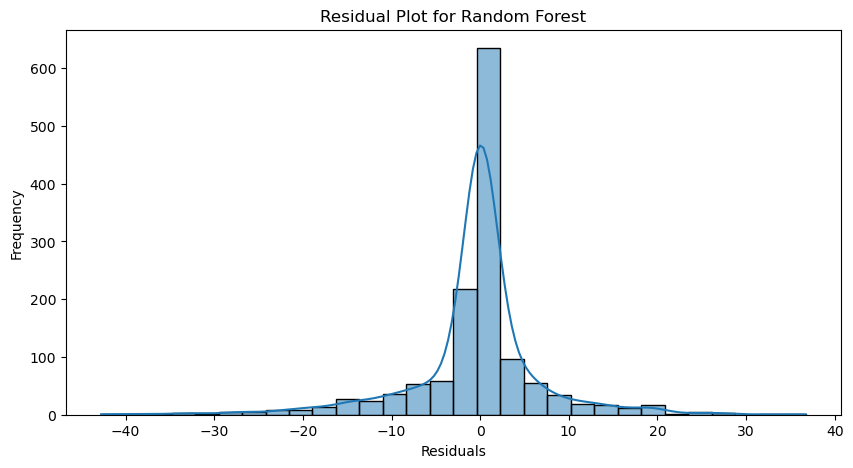

In [ ]:
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7364\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




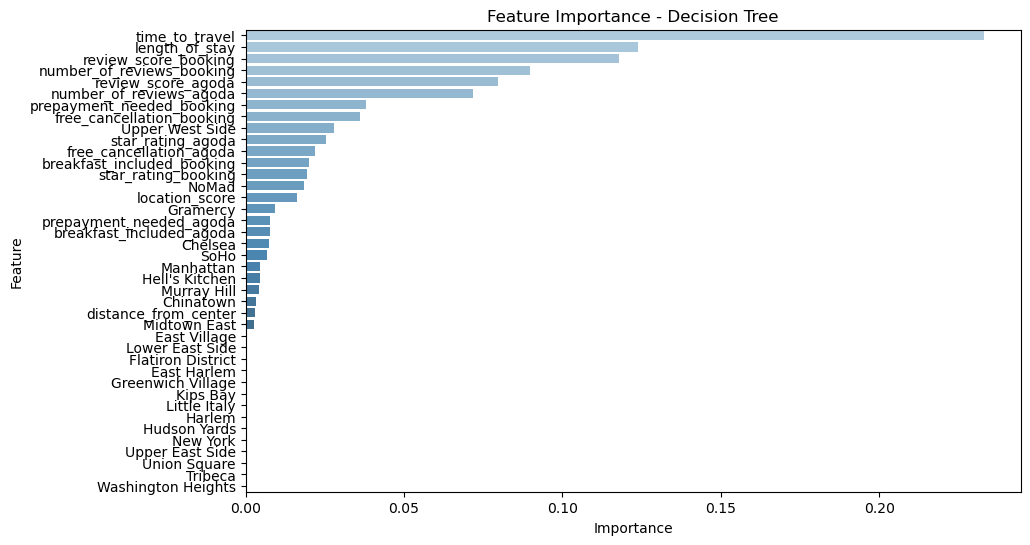

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7364\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




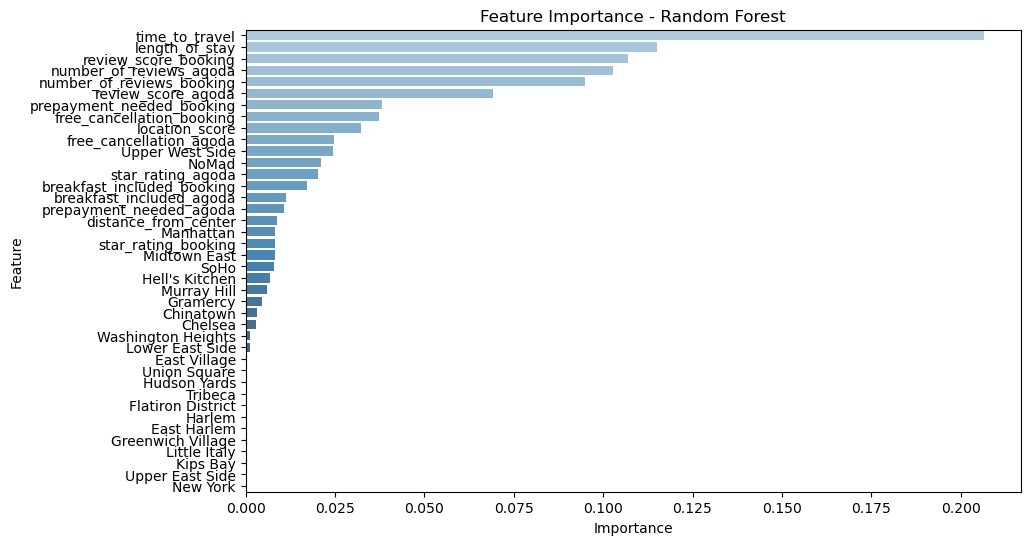

In [ ]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7364\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




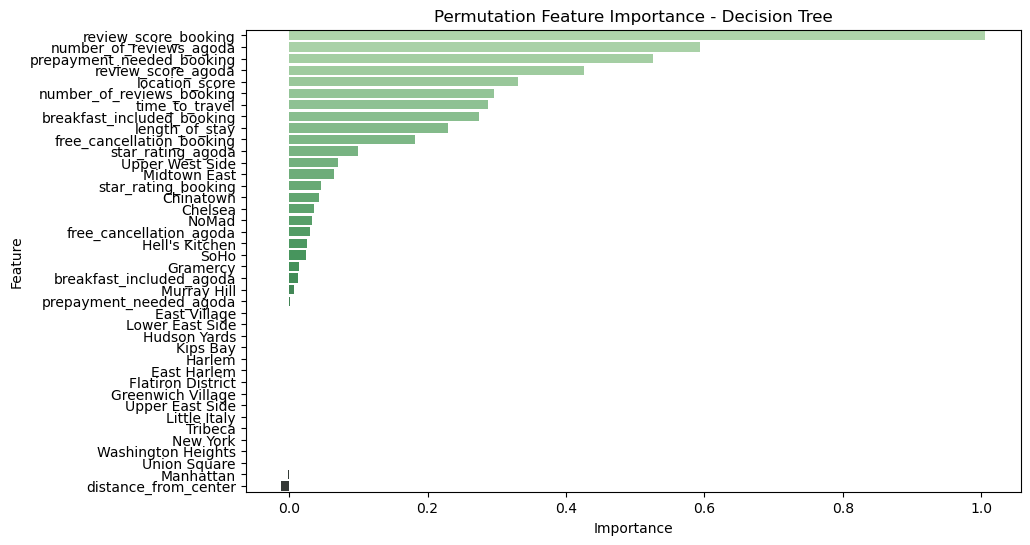

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7364\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




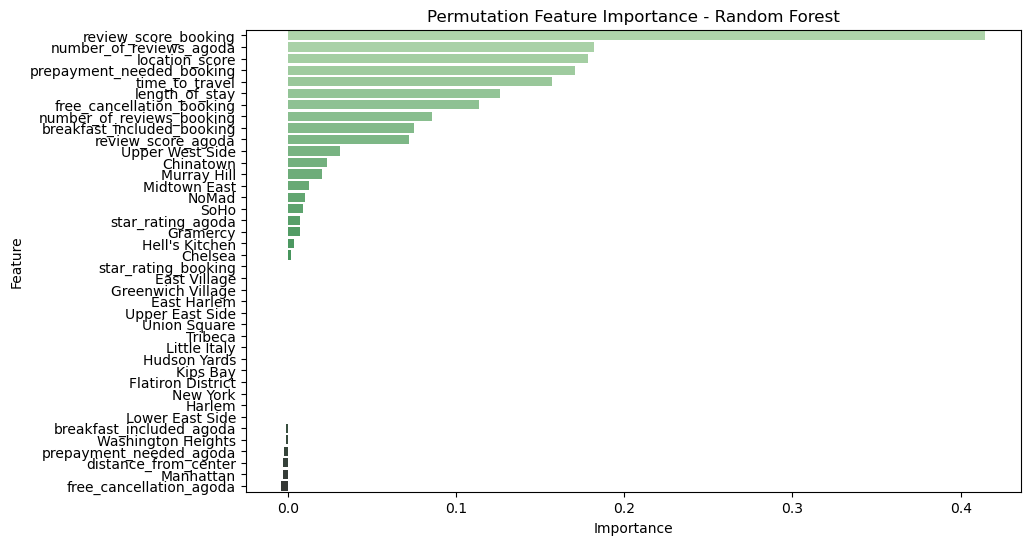

In [ ]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.show()
